In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from random import sample, choice
import cv2 as cv

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, RandomFlip, Resizing, Rescaling, RandomFlip, RandomRotation, SpatialDropout2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
path = ""

train_image_path = os.path.join(path, '/kaggle/input/camvid/CamVid/train/')
train_mask_path = os.path.join(path, '/kaggle/input/camvid/CamVid/train_labels/')
train_image_list_orig = os.listdir(train_image_path)
train_image_list = [train_image_path+i for i in train_image_list_orig]
train_mask_list = [train_mask_path+i.split('.')[0] + '_L.' + i.split('.')[1] for i in train_image_list_orig]

test_image_path = os.path.join(path, '/kaggle/input/camvid/CamVid/test/')
test_mask_path = os.path.join(path, '/kaggle/input/camvid/CamVid/test_labels/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig]
test_mask_list = [test_mask_path+i.split('.')[0] + '_L.' + i.split('.')[1] for i in test_image_list_orig]

train_image_list = train_image_list + test_image_list
train_mask_list = train_mask_list + test_mask_list

val_image_path = os.path.join(path, '/kaggle/input/camvid/CamVid/val/')
val_mask_path = os.path.join(path, '/kaggle/input/camvid/CamVid/val_labels/')
val_image_list_orig = os.listdir(val_image_path)
val_image_list = [val_image_path+i for i in val_image_list_orig]
val_mask_list = [val_mask_path+i.split('.')[0] + '_L.' + i.split('.')[1] for i in val_image_list_orig]

In [ ]:
class_map_path = os.path.join(path, '/kaggle/input/camvid/CamVid/')
class_map_df = pd.read_csv('/kaggle/input/camvid/CamVid/' + "class_dict.csv")

class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))

len(class_map)

def form_2D_label(mask,class_map):
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    for i, rgb in enumerate(class_map):
        label[tf.reduce_all((mask == rgb), axis=2) ] = i

    return label

In [ ]:
train_paths = list(zip(train_image_list, train_mask_list))
val_paths = list(zip(val_image_list, val_mask_list))

# DataGenerator

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, pair, class_map, batch_size=16, dim=(256,256,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.pair_len = len(pair)
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.pair_len / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [i for i in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def gen(self):
        'Generate one batch of data'
        # Generate data
        for i in range(0, self.pair_len):
            # Store sample
            batch_imgs = list()
            batch_labels = list()
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            batch_labels.append(label)

        yield np.array(batch_imgs) ,np.array(batch_labels)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.pair_len)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)
            img = cv.convertScaleAbs(img, alpha=1.25, beta=2.5)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            # label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)

        return np.array(batch_imgs) ,np.array(batch_labels)

In [ ]:
train_generator = DataGenerator(train_paths,class_map,batch_size=8, dim=(384, 384, 3) ,shuffle=True)

In [ ]:
X, y = train_generator.__getitem__(1)

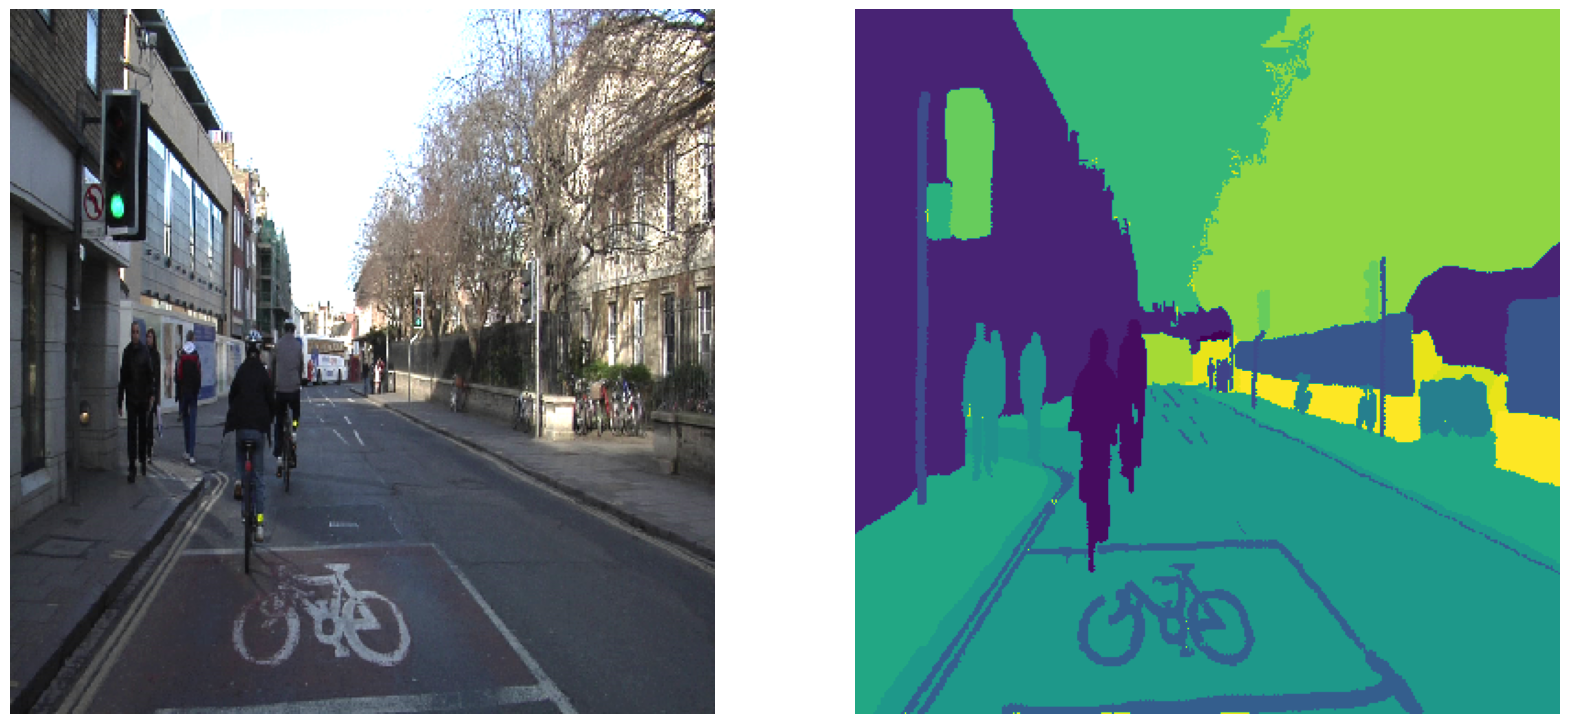

In [ ]:
plt.figure(figsize=(20, 30))

plt.subplot(1,2,1)
plt.imshow(X[0, :, :, :])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(y[0, :, :])
plt.axis('off')

plt.show()

In [ ]:
val_generator = DataGenerator(val_paths, class_map, batch_size=4, dim=(384, 384, 3) ,shuffle=True)

# MobileNetV2-UNET

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[384, 384, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
def Conv2DTranBlock(input, n_filters, kernel_size, strides, activation):
        x =  Conv2DTranspose(n_filters,
                         kernel_size,
                         strides= strides,
                         activation=activation,
                         padding='same',
                         kernel_initializer='he_normal',
                         bias_initializer='he_normal')(input)
        return x


def Conv2DBlock(input, n_filters, kernel_size, activation):
        x =  Conv2D(n_filters,
                         kernel_size,
                         activation=activation,
                         padding='same',
                         kernel_initializer='he_normal',
                         bias_initializer='he_normal')(input)
        return x


def upsampling_module(expansive_input, contractive_input, n_filters=64):
    up = Conv2DTranBlock(expansive_input, n_filters, (2,2), (2,2), 'leaky_relu')
    merge = concatenate([up, contractive_input], axis=3)
    x =  Conv2DBlock(merge, n_filters, (2,2), 'leaky_relu')
    x =  Conv2DBlock(x, n_filters, (2,2), 'leaky_relu')
    x = BatchNormalization()(x)
    x = SpatialDropout2D(0.2)(x)
    return x


def pre_unet_model(input_size=(384, 384, 3), n_filters=64, n_classes=32):
    inputs = Input(input_size)

    encoding = down_stack(inputs)
    # Decoding
    ublock = upsampling_module(encoding[4], encoding[3], n_filters=n_filters*8)    #down_stack.outputs[3].shape[-1]
    ublock = upsampling_module(ublock, encoding[2], n_filters=n_filters*4)
    ublock = upsampling_module(ublock, encoding[1], n_filters=n_filters*2)
    ublock = upsampling_module(ublock, encoding[0], n_filters=n_filters)
    conv = Conv2DTranspose(n_filters,
                         (2,2),
                         (2,2),
                         padding='same',
                         kernel_initializer='he_normal')(ublock)
    conv =  Conv2D(n_classes, (2,2), padding='same', kernel_initializer='he_normal', bias_initializer='he_normal')(conv)
    conv =  Conv2D(n_classes, (1,1), padding='same', kernel_initializer='he_normal', bias_initializer='he_normal')(conv)
    model = tf.keras.Model(inputs=inputs, outputs=conv)
    return model

In [ ]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

MUnet = pre_unet_model() # define your model normally
MUnet.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy'])

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

# Predict

In [ ]:
def show_predictions():
    sample = choice(val_paths)
    sample_image= img_to_array(load_img(sample[0] , target_size= (384, 384, 3)))
    sample_mask = img_to_array(load_img(sample[1] , target_size= (384, 384, 3)))

    def make_prediction(model,img_path,shape):
        img= img_to_array(load_img(img_path , target_size= shape))/255.
        img = np.expand_dims(img,axis=0)
        labels = model.predict(img)
        labels = np.argmax(labels[0],axis=2)
        return labels

    def form_colormap(prediction,mapping):
        h,w = prediction.shape
        color_label = np.zeros((h,w,3),dtype=np.uint8)
        color_label = mapping[prediction]
        color_label = color_label.astype(np.uint8)
        return color_label

    def display(display_list):
        plt.figure(figsize=(15, 15))

        title = ['Input Image', 'True Mask', 'Predicted Mask']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()


    pred_label = make_prediction(MUnet, sample[0], (384, 384, 3))
    pred_colored = form_colormap(pred_label,np.array(class_map))

    display([sample_image, sample_mask, pred_colored])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Train

1/1 [==============================] - 0s 24ms/step


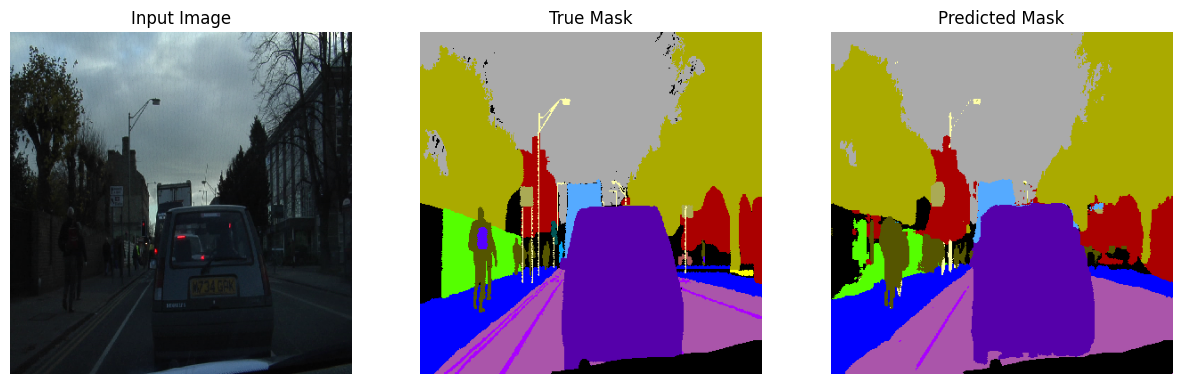


Sample Prediction after epoch 25

75/75 [==============================] - 113s 2s/step - loss: 0.3060 - accuracy: 0.9063 - val_loss: 0.4439 - val_accuracy: 0.8801


In [ ]:
model_history = MUnet.fit(train_generator, steps_per_epoch=train_generator.__len__() ,epochs=25,
                              validation_data=val_generator, validation_steps=val_generator.__len__(), callbacks=[DisplayCallback()])

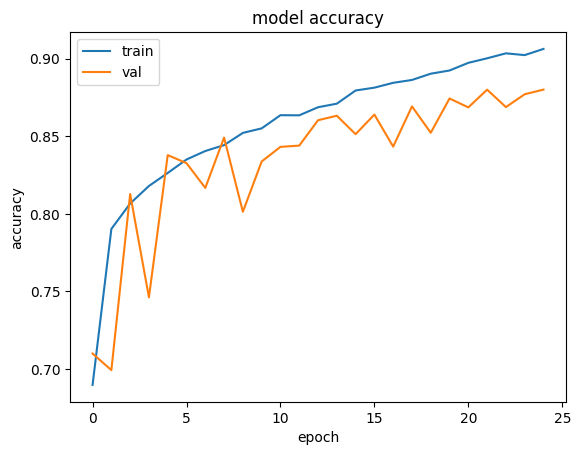

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 23ms/step


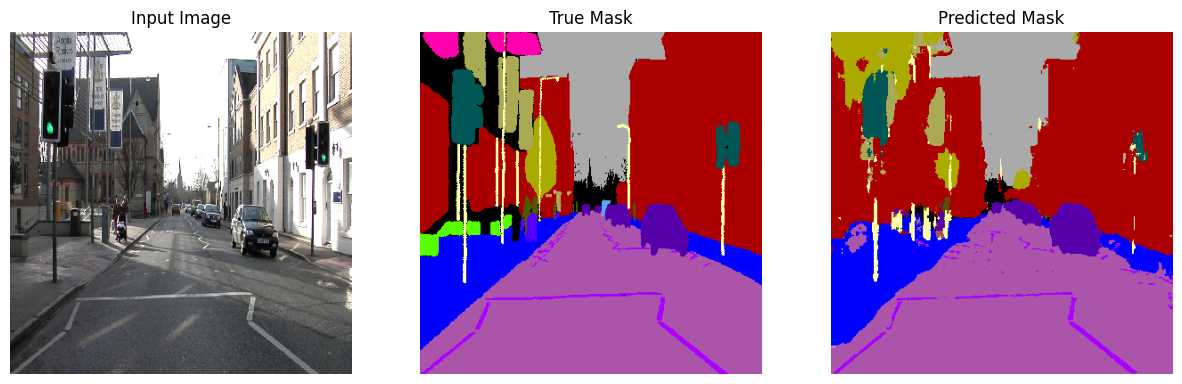

1/1 [==============================] - 0s 23ms/step


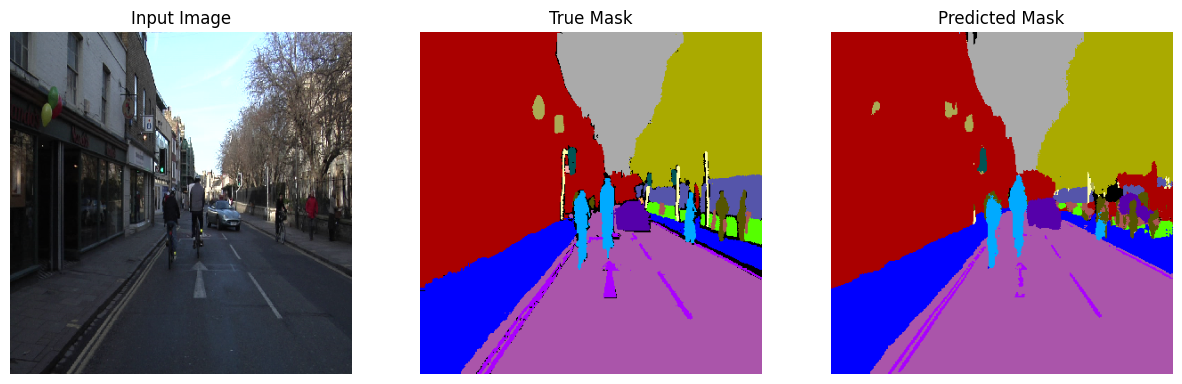

1/1 [==============================] - 0s 23ms/step


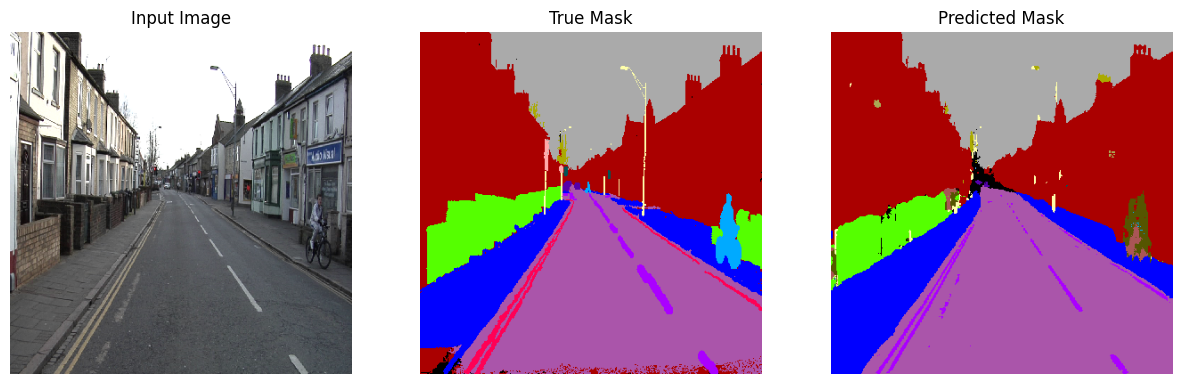

1/1 [==============================] - 0s 23ms/step


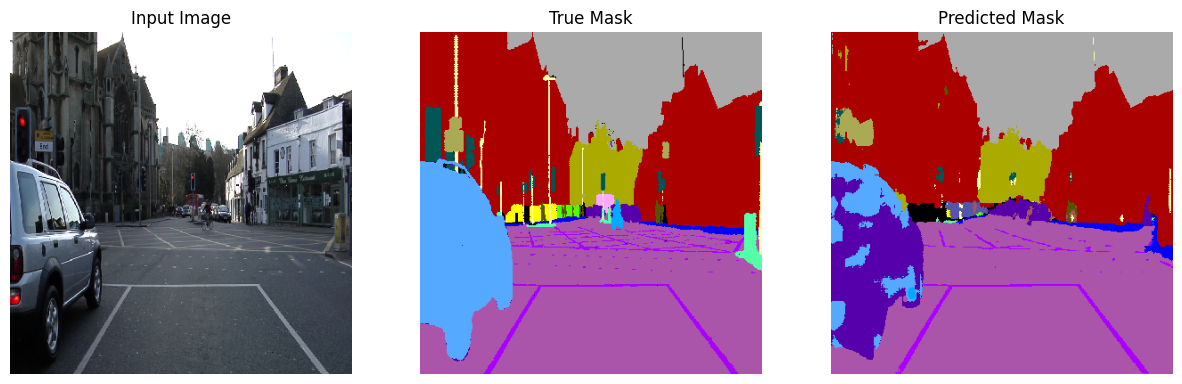

1/1 [==============================] - 0s 23ms/step


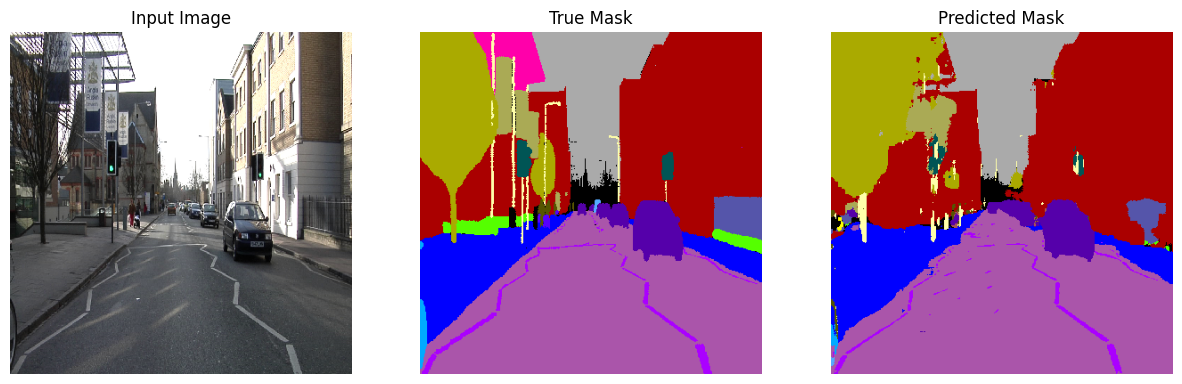

In [ ]:
for i in range(0,5):
    show_predictions()